https://discourse.pymc.io/t/bernoulli-samples-all-the-same/1297

In [11]:
%pylab inline
import pymc3 as pm
import theano.tensor as tt
import theano

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['trace', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [12]:
N_EXP = 200
time_const = 5

t_vec = np.linspace(0.1, 15, 20)
p_vals = np.exp(-1 * t_vec / time_const)

mu_0 = 2
mu_1 = 5
b0 = np.random.binomial(n=1, p=p_vals, size=(N_EXP, len(p_vals)))
data = (b0 * np.random.poisson(lam=mu_1, size=b0.shape) +
        (1 - b0) * np.random.poisson(lam=mu_0, size=b0.shape))

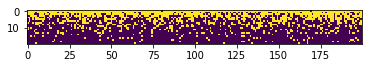

In [13]:
plt.imshow(b0.T);

In [14]:
muz0 = theano.shared(np.asarray([mu_1, mu_0]))

In [16]:
with pm.Model() as poisson_model:
    # Prior on time constant
    BoundedNormal = pm.Bound(pm.Normal, lower=0.1)
    tt2 = BoundedNormal('tt2', mu=2., sd=10.)
    # Form expected for decay of p(t)
    pzero = pm.Deterministic('p', tt.exp(-1*t_vec/tt2))
    # Using p values draw Bernoulli samples
    b = pm.Bernoulli('b', p=pzero, shape=b0.shape)
    # mu is either mu0 or mu1 depending on result of Bernoulli sample
    muz2 = muz0[b]
    
    likelihood = pm.Poisson('like', mu=muz2, shape=len(t_vec), observed=data)
    trace = pm.sample(1000, tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [b]
>NUTS: [tt2]
100%|██████████| 2000/2000 [00:06<00:00, 316.79it/s]


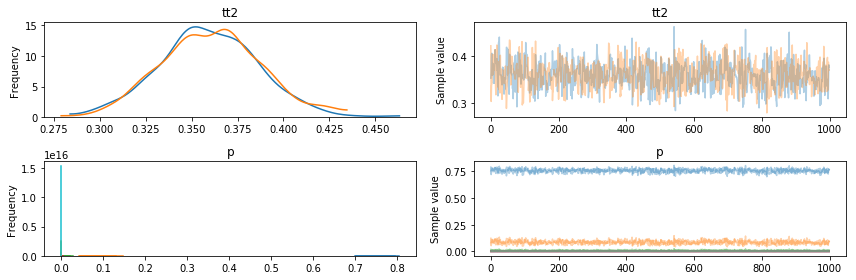

In [18]:
pm.traceplot(trace, varnames=['tt2', 'p']);

In [22]:
trace['b'][0,:,:]

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

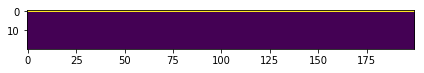

In [21]:
plt.imshow(trace['b'].mean(axis=0).T)

In [7]:
with pm.Model() as poisson_model:
    # Prior on time constant
    BoundedNormal = pm.Bound(pm.Normal, lower=0.1)
    tt2 = BoundedNormal('tt2', mu=2., sd=10.)
    # Form expected for decay of p(t)
    pzero = pm.Deterministic('p', tt.exp(-1*t_vec/tt2))
    # Using p values draw Bernoulli samples
#     b = pm.Bernoulli('b', p=pzero, shape=len(t_vec))
    # mu is either mu0 or mu1 depending on result of Bernoulli sample
    muz = (pzero*mu_1 + (1 - pzero)*mu_0)
    
    likelihood = pm.Poisson('like', mu=muz, shape=len(t_vec), observed=data)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tt2]
100%|██████████| 2000/2000 [00:02<00:00, 678.07it/s]


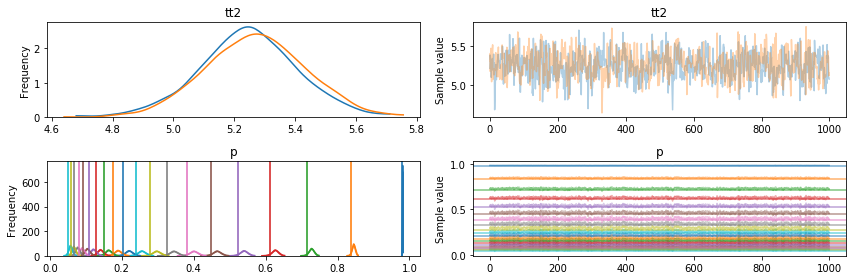

In [8]:
pm.traceplot(trace, lines=dict(p=p_vals));

In [40]:
with pm.Model() as poisson_model:
    # Prior on time constant
    BoundedNormal = pm.Bound(pm.Normal, lower=0.1)
    tt2 = BoundedNormal('tt2', mu=2., sd=10.)
    # Form expected for decay of p(t)
    pzero = pm.Deterministic('p', tt.exp(-1*t_vec/tt2))
    
    like0 = pm.Poisson.dist(mu=mu_0, shape=len(t_vec))
    like1 = pm.Poisson.dist(mu=mu_1, shape=len(t_vec))
    obs = pm.Potential('like', tt.log(1-pzero)+like0.logp(data)+
                               tt.log(pzero)+like1.logp(data))
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tt2]
100%|██████████| 2000/2000 [00:03<00:00, 637.00it/s] 


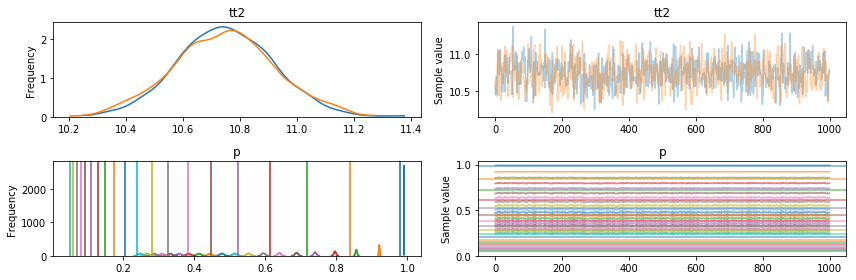

In [41]:
pm.traceplot(trace, lines=dict(p=p_vals));